[![Open In Colab](images/colab-badge.svg)](https://colab.research.google.com/github/BRomans/UnicornPythonEssentialsToolkit/blob/main/notebooks/P300_Classification.ipynb)

In [1]:
!pip install mne # Use only on Google Colab


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


# Introduction
The following notebook has been developed by Michele Romani, PhD student at the University of Trento. The notebook is part of his research on Brain-Computer Interfaces for Gaming using event-related potentials. The notebook can be used for educational purposes together with the dataset available in the [repository](https://github.com/BRomans/CortexToolkit).
Copying and distribution of the notebook or part of its content must include the original author and the link to the repository.

_University of Trento, 2024_

__©Michele Romani__

## P300 and the Oddball Paradigm
The P300 is a positive deflection in the event-related potential (ERP) that occurs approximately 300 ms after the presentation of a rare or unexpected stimulus. The P300 is elicited by the oddball paradigm, a simple experimental design in which participants are presented with a series of stimuli, some of which are rare or deviant. The P300 is thought to reflect cognitive processes such as attention, memory, and decision-making. The P300 has been extensively studied in the context of brain-computer interfaces (BCIs) and has been used to develop applications such as spellers, control interfaces, and neurofeedback systems.
In this study we focus on auditory P300, which is elicited by auditory stimuli such as beeping tones.

The paradigm followed the following stimuli sequence 

![Auditory Oddball](images/auditory-oddball-paradigm.png)


The target stimulus is presented 10 times over 90 trials, in a pseudo-randomized cadence.
The elicited P300 can be observed in the ERP waveform as a positive deflection approximately 300 ms after the onset of the target stimulus.

![P300](images/p300.png)


## Classification

### Load Libraries and Data


Loaded data with shape:(13626, 8) and trigger shape: (13626,)
That means we have 13626 samples and 8 channels.
Creating RawArray with float64 data, n_channels=8, n_times=13626
    Range : 0 ... 13625 =      0.000 ...    54.500 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=13626
    Range : 0 ... 13625 =      0.000 ...    54.500 secs
Ready.


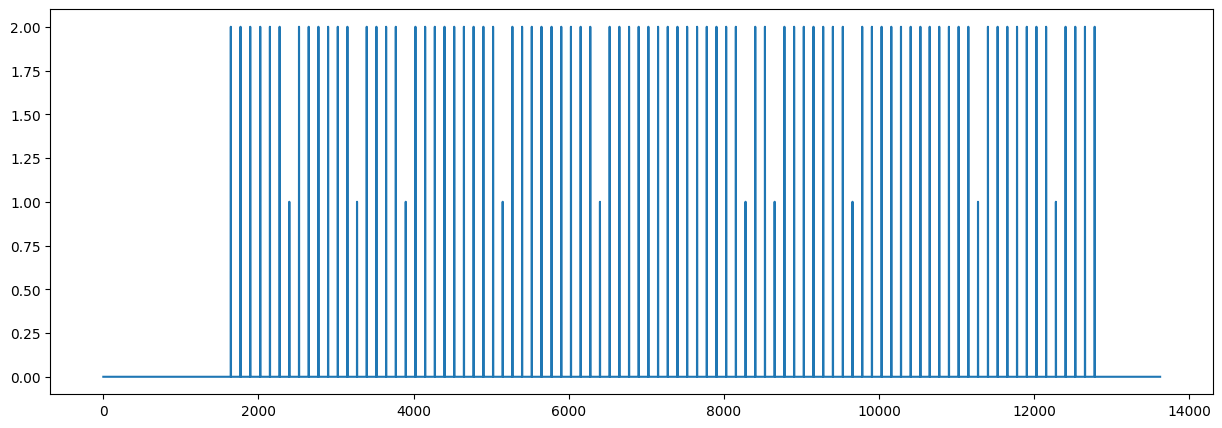

In [2]:
from mne import find_events
from utils.loader import load_data, convert_to_mne
from utils.preprocessing import extract_epochs, basic_preprocessing_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
from utils.evaluation import plot_feature_vector, plot_confusion_matrix, plot_cross_validated_confusion_matrix, plot_data_distribution
plt.rcParams['figure.figsize'] = [15, 5]

%matplotlib inline
#%matplotlib qt

fs = 250
chs = ["Fz", "C3", "Cz", "C4", "Pz", "PO7", "Oz", "PO8"]


eeg, trigger, dataframe = load_data("../data/aep/auditory_erp_eyes_open_S1.csv", fs=fs, skiprows=5, delimiter=',')
print("Loaded data with shape:" + str(eeg.shape) + " and trigger shape: " + str(trigger.shape))
print("That means we have " + str(eeg.shape[0]) + " samples and " + str(eeg.shape[1]) + " channels.")

 # Convert to MNE format
raw_data = convert_to_mne(eeg, trigger, fs=fs, chs=chs, recompute=False) # recompute=True to recalculate the event labels if the values are negative
plt.plot(trigger)
plt.show()

### Data Preparation


1. Extract events and event ids
2. Preprocess the data  
3. Epoching and baseline correction
4. Resample and split the data


#### 1.Extract events and event ids

90 events found on stim channel STI
Event IDs: [1 2]
Using matplotlib as 2D backend.


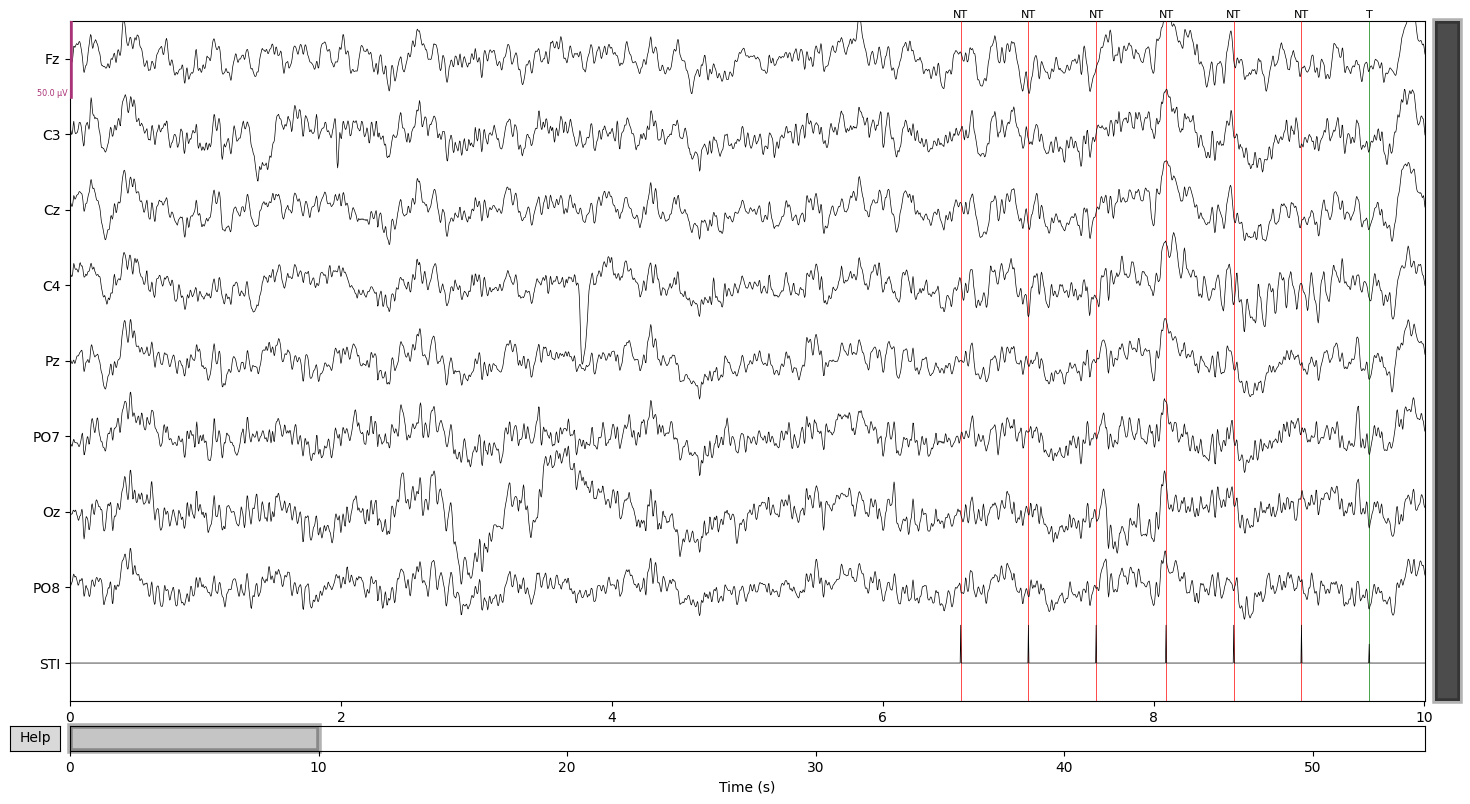

In [3]:
import mne
mne.set_config('MNE_BROWSE_RAW_SIZE', '15,8') #TODO temporary workaround


ev_ids = {'NT': 2, 'T':1}
event_colors = {2:'r', 1:'g'}
stim_channel = 'STI'
events = find_events(raw_data, stim_channel=stim_channel)
raw_data.plot(events=events, event_id=ev_ids, event_color=event_colors, color = 'Black', block = True, clipping=None, scalings=25e-6)
plt.show()

#### 2.Preprocess the data
We apply the basic preprocessing steps to the data, such as bandpass filtering and notch filtering. The MNE functions have been wrapped by a single preprocessing pipeline.

In [4]:
filtered = basic_preprocessing_pipeline(raw_data, lp_freq=2, hp_freq=20, notch_freqs=(50,60))

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 3.50 Hz
- Upper transition bandwidth: 3.50 Hz
- Filter length: 237 samples (0.948 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 21.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


#### 3.Epoching with baseline correction
The baseline segment is defined as the interval before the onset of the event. The mean of this interval is subtracted from the entire epoch to correct for the baseline shift.

In [5]:

baseline=(-.2, 0)
eps = extract_epochs(data=filtered, events=events, ev_ids=ev_ids, tmin=-0.2, tmax=0.8, baseline=baseline)
eps.apply_baseline(baseline)

X = eps.get_data(picks='eeg')

y = eps.events[:,-1]


print(X.shape, y.shape)

Not setting metadata
90 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 90 events and 251 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
(90, 8, 251) (90,)


#### 4.Resample and split the data
There main reason for resampling the data is to avoid unbalanced classes. The number of samples in the minority class is much lower than the majority class. 
This can lead to a model that is biased towards the majority class. 
To avoid this, we can oversample the minority class or undersample the majority class (or both!).
<b>Important:</b> check how to use the "sampling_strategy" parameter in the [RandomOverSampler](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html) and [RandomUnderSampler](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html) classes. More information on the imbalanced-learn documentation.

In [27]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

random_state = 32


num_epochs = len(X)

# Reshape the data for LDA
X_r = X.reshape((num_epochs, -1))
print(X_r.shape)
y_r = le.fit_transform(y)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_r, y_r, test_size=0.4, random_state=33)
print(X_train.shape, X_test.shape)
print(y_test)

(90, 2008)
(54, 2008) (36, 2008)
[0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1]


Plotting the feature vector helps to understand the data structure and the relationship between the channels and the feature vector. 
In this case, the feature vector is the result of the reshaping of the epochs using `X.reshape(num_epochs, -1)`, which flattens the channels in a single vector.

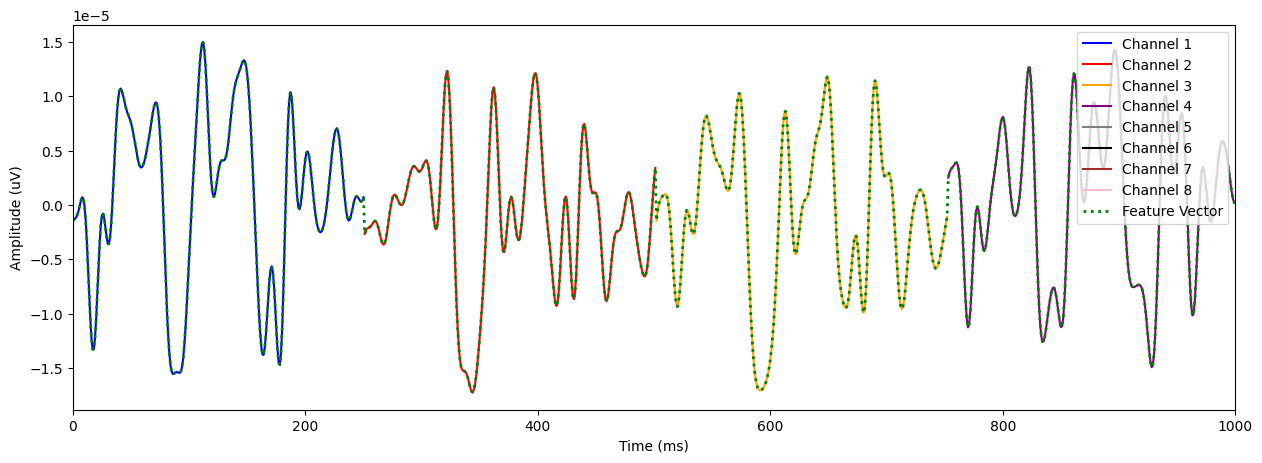

In [28]:
plot_feature_vector(X, X_r, seg_len=251, epoch=0)

### Classification
1. Choosing a classifier
2. Rescale the data and train_classifier LDA
3. Using ensemble methods: Random Forest
4. Cross-Validation

#### 1.Choosing a classifier
For classification, we use LDA, a model that fits a Gaussian density for each class and has been shown to be a good classifier for ERP data in previous studies [1].
LDA makes two assumptions:
- The data is normally distributed, when plotted it looks like a bell curve
- The classes have the same covariance matrix, which means that the variance of the features is the same for all classes.

So first we can check the distribution by plotting the mean of the feature vector for the training and testing sets as a histogram.
Then we can rescale the data and fit the model.
Other classifiers can be used, such as SVM, or variants of LDA such as QDA.
[1] D. J. Krusienski et al., “A comparison of classification techniques for the P300 Speller,” J Neural Eng, vol. 3, no. 4, pp. 299–305, Dec. 2006, doi: 10.1088/1741-2560/3/4/007.


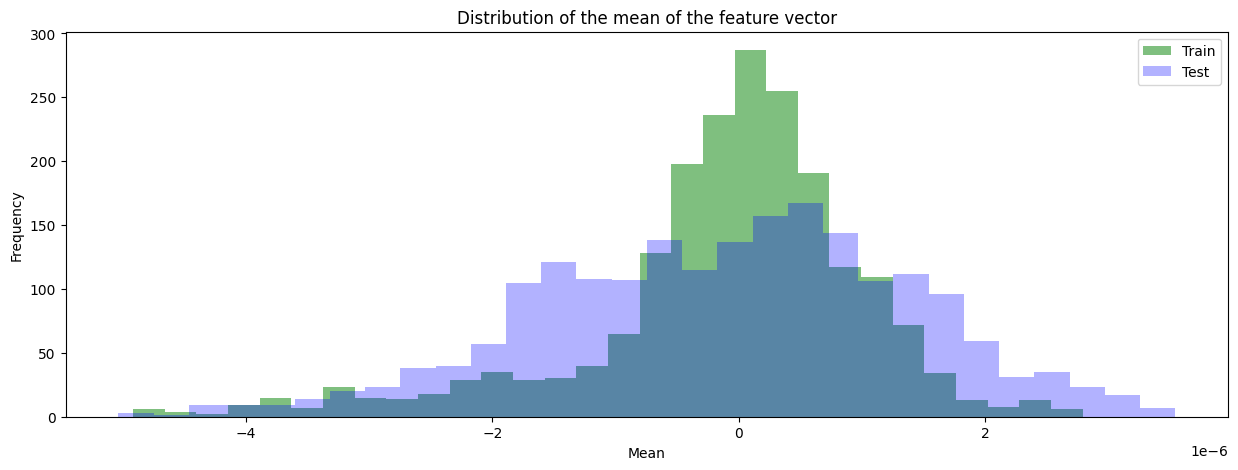

In [8]:
plot_data_distribution(X_train, X_test)

#### 2.Rescale the data and train_classifier LDA
The feature vector is rescaled to have a mean of 0 and a standard deviation of 1. This is important for the LDA model, which assumes that the data is normally distributed.

<b>Important:</b> fit the scaler on the training set and transform the test set. 
If you fit the scaler on the test set, you are leaking information from the test set into the training set.


Class 0 count: 6, Class 1 count: 48
Accuracy: 0.89 F1 Score: 0.94


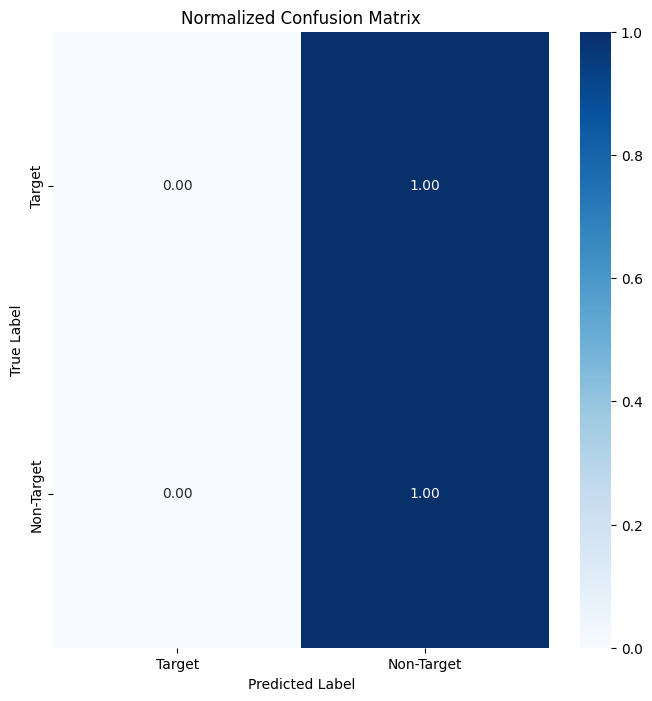

In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.svm import SVC

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) 

# Apply LDA

zero_count = np.sum(y_train == 0)
one_count = np.sum(y_train == 1)

print(f'Class 0 count: {zero_count}, Class 1 count: {one_count}')

class_weights = {0: one_count, 1: zero_count}

model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')

print(f'Accuracy: {accuracy:.2f} F1 Score: {f1:.2f}')
plot_confusion_matrix(y_test, y_pred, classes=['Target', 'Non-Target'], normalize=True)

#### 3.Cross-Validation
Cross-validation is important to avoid overfitting and to get a better estimate of the model's performance.
We use Stratifed K-Fold cross-validation, which ensures that each fold has the same proportion of classes as the entire dataset.
To visualize the goodness of the model, we can plot the confusion matrix for each fold. 

Cross-validated accuracy: 0.87 (+/- 0.07) F1-Score: 0.94 (+/- 0.02)


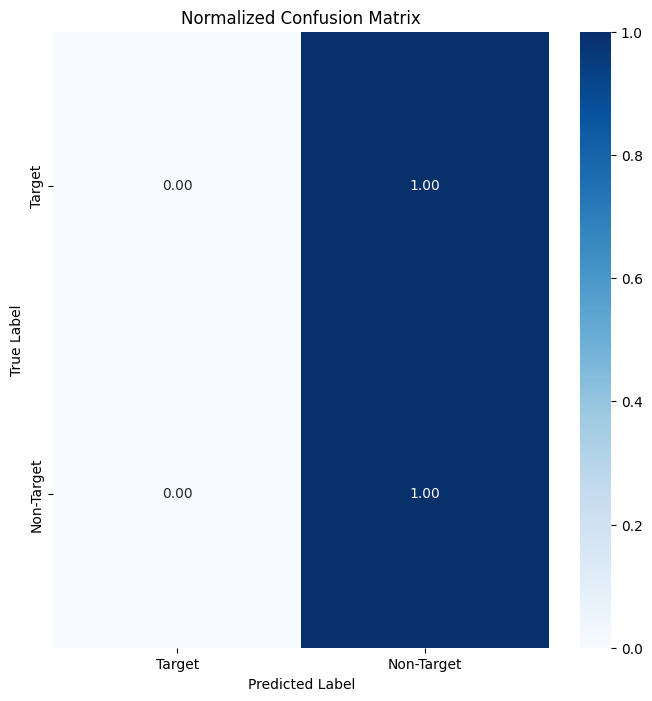

In [31]:
scaler = StandardScaler()
X_rescaled = scaler.fit_transform(X_r)
n_splits = 5

# Use cross-validation
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train, y_train, cv=cv)
f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1', error_score=0)


# Print cross-validated accuracy
print(f'Cross-validated accuracy: {np.mean(scores):.2f} (+/- {np.std(scores):.2f}) F1-Score: {np.mean(f1):.2f} (+/- {np.std(f1):.2f})')

plot_cross_validated_confusion_matrix(X_train, y_train, model, cv=cv, classes=['Target', 'Non-Target'], normalize=True)

Additionally, we can plot the ROC curve and calculate the AUC score to evaluate the model's performance.
ROC curves are useful to visualize the trade-off between sensitivity and specificity for different thresholds.
The AUC score is a measure of the model's performance, with a score of 0.5 indicating a random classifier and a score of 1 indicating a perfect classifier.

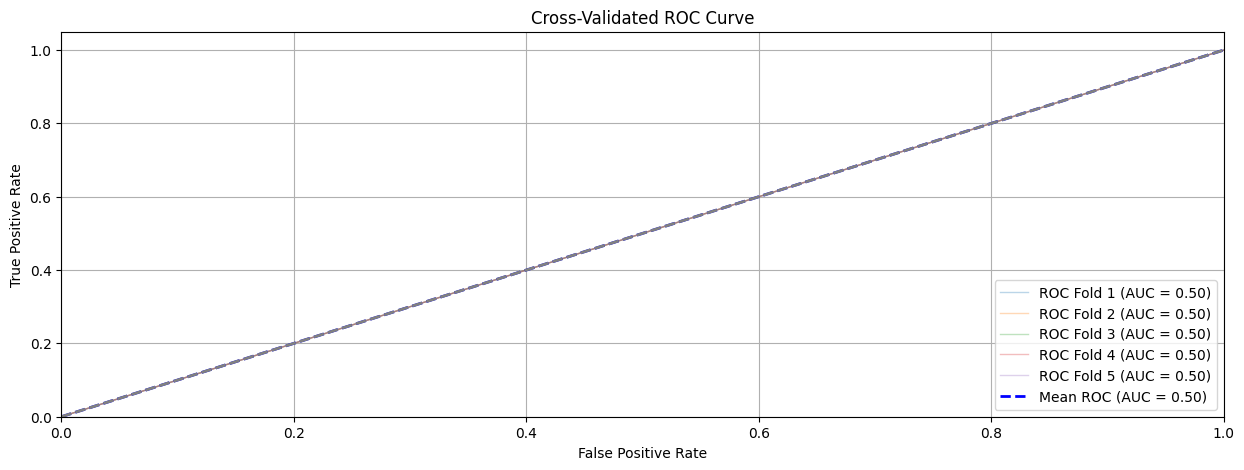

In [11]:
from utils.evaluation import plot_cross_validated_roc_curve

plot_cross_validated_roc_curve(X=X_train, y=y_train, clf=model, n_splits=n_splits)

#### 4.Handling Imbalanced Data
In this dataset, we have an imbalanced number of target and non-target trials. This can lead to a biased model that favors the majority class. To address this issue, we can use resampling techniques such as oversampling the minority class or undersampling the majority class. Here, we demonstrate how to use RandomUnderSampler to balance the classes by undersampling the majority class.

Resampled dataset shape: (96, 2008) (96,)
Resampled Accuracy: 0.81 F1 Score: 0.88


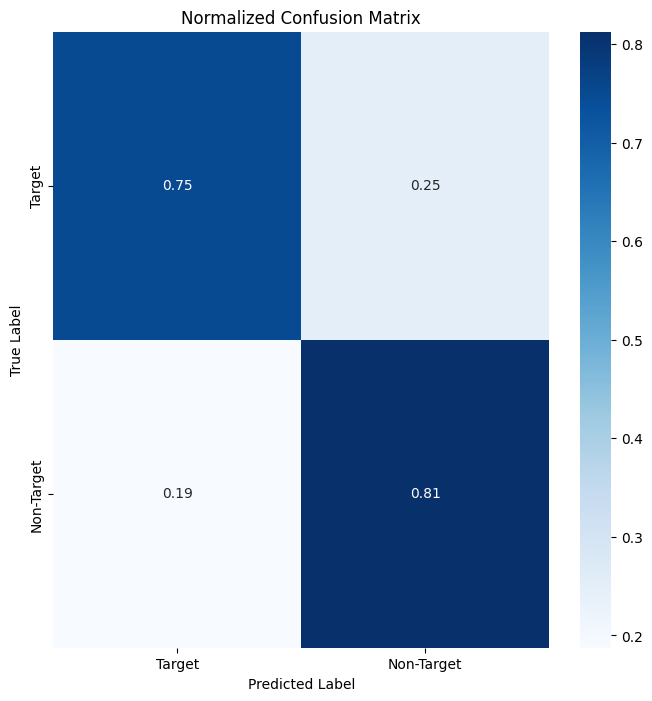

In [39]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

rus = RandomUnderSampler(random_state=random_state, sampling_strategy='majority')
ros = RandomOverSampler(random_state=random_state, sampling_strategy='minority')

X_res, y_res = ros.fit_resample(X_train, y_train)
print("Resampled dataset shape:", X_res.shape, y_res.shape)

model_res = LinearDiscriminantAnalysis()
model_res.fit(X_res, y_res)
y_pred_res = model_res.predict(X_test)

accuracy_res = accuracy_score(y_test, y_pred_res)
f1_res = f1_score(y_test, y_pred_res, average='binary')
print(f'Resampled Accuracy: {accuracy_res:.2f} F1 Score: {f1_res:.2f}')
plot_confusion_matrix(y_test, y_pred_res, classes=['Target', 'Non-Target'], normalize=True)


## Exercises

1. Try changing the bandpass filter frequencies in the preprocessing pipeline. How does it affect the classification performance?
2. Try varying the size of the epochs (tmin and tmax) during epoch extraction. How does it affect the classification performance?
3. Try different balancing strategies using imbalanced-learn, such as oversampling the minority class or using SMOTE. How does it affect the classification performance?
4. Try changin the split ratio between training and testing sets. How does it affect the classification performance?
5. Experiment with different classifiers, such as SVM or Random Forest. How do they compare to LDA in terms of accuracy and F1 score?
6. Now try to load your own dataset and apply the same pipeline. How does it perform on your data?